In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from typing import Tuple
import optuna
import re
from pathlib import Path


In [162]:
sns.set_theme(style='whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Leitura e pré-processamento de dados.

In [163]:
def read_csv_folder(input_path: Path) -> pd.DataFrame:
    """
    Lê todos os arquivos CSV na pasta especificada e concatena em um único DataFrame.
    """
    df_full = pd.DataFrame()
    
    if not input_path.exists():
        raise FileNotFoundError(f"O diretório {input_path} não existe.")
    
    if not any(input_path.glob('*.csv')):
        raise FileNotFoundError(f"Nenhum arquivo CSV encontrado no diretório {input_path}.")
    for file in input_path.glob('*.csv'):
        print(f"Processando arquivo: {file.name}")
        city_regex = r'(\w+)_\d{4}.csv'
        match = re.match(city_regex, file.name)
        city_name = match.group(1) if match else 'Desconhecido'
        print(f"Nome da cidade: {city_name}")
        df = pd.read_csv(file, skiprows=2)
        df['City'] = city_name
        df_full = pd.concat([df_full, df], ignore_index=True)
    return df_full


In [164]:
df  = read_csv_folder(Path('data/'))

Processando arquivo: Natal_2020.csv
Nome da cidade: Natal
Processando arquivo: Natal_2021.csv
Nome da cidade: Natal
Processando arquivo: Natal_2022.csv
Nome da cidade: Natal
Processando arquivo: Natal_2023.csv
Nome da cidade: Natal
Processando arquivo: Natal_2024.csv
Nome da cidade: Natal


In [165]:
df['Year'].unique()

array([2020, 2021, 2022, 2023, 2024])

In [166]:
def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(['Minute','Cloud Type', 'Ozone','Solar Zenith Angle', 'Surface Albedo',
                    'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'DHI', 'DNI', 'Fill Flag', 'Cloud Fill Flag', 'Aerosol Optical Depth','Alpha','SSA','Asymmetry'], axis = 1)
    df = df.dropna()
    # Combine year, month, day, hour into a single datetime column
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    # Extract useful time-based features
    df['DayOfYear'] = df['Datetime'].dt.dayofyear
    df['HourOfDay'] = df['Datetime'].dt.hour
    df['Month'] = df['Datetime'].dt.month
    # Optionally, drop original columns if not needed
    df = df.drop(['Month', 'Day', 'Hour', 'Datetime'], axis=1)
    return df

In [167]:
def data_scaling_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    # Codificar a coluna 'City' usando One-Hot Encoding
    city_encoded = one_hot_encoder.fit_transform(df[['City']])
    city_encoded_df = pd.DataFrame(city_encoded, columns=one_hot_encoder.get_feature_names_out(['City']), index=df.index)
    # Concatenar as colunas codificadas com o restante do DataFrame (exceto 'City')
    df_no_city = df.drop(['City'], axis=1)
    df_all = pd.concat([df_no_city, city_encoded_df], axis=1)
    scaler = MinMaxScaler()
    df_all['DayOfYear'] = np.sin(df_all['DayOfYear'] * (2 * np.pi / 365))  # Normalização do dia do ano
    df_all['HourOfDay'] = np.sin(df_all['HourOfDay'] * (2 * np.pi / 24))  # Normalização da hora do dia
    columns_to_scale = [col for col in df_all.columns if col not in ['Year', 'DayOfYear', 'HourOfDay']]
    df_all[columns_to_scale] = scaler.fit_transform(df_all[columns_to_scale])
    # Uso dos dados até 2023 para treino e 2024 para teste.
    df_train = df_all[df_all['Year'] <= 2022]
    df_test = df_all[df_all['Year'] >= 2023]
    #Remove a coluna 'Year' dos dataframes.
    df_train = df_train.drop(['Year'], axis=1)
    df_test = df_test.drop(['Year'], axis=1)
    # Reset index for all dataframes
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    return df_train, df_test

In [168]:
df = data_preprocessing(df)
df.tail(10)

,Year,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,City,DayOfYear,HourOfDay
87590,2024,29.3,23.8,309,72.23,1007,4.2,116,0.0,Natal,366,19
87591,2024,28.8,23.8,190,74.41,1008,4.2,116,0.0,Natal,366,19
87592,2024,28.4,24.0,82,77.28,1008,4.2,115,0.0,Natal,366,20
87593,2024,28.2,24.1,8,78.25,1009,4.2,115,0.0,Natal,366,20
87594,2024,28.0,24.3,0,80.35,1009,4.3,115,0.0,Natal,366,21
87595,2024,27.8,24.3,0,81.28,1009,4.3,115,0.0,Natal,366,21
87596,2024,27.7,24.5,0,82.56,1010,4.3,115,0.0,Natal,366,22
87597,2024,27.7,24.5,0,82.56,1010,4.4,115,0.0,Natal,366,22
87598,2024,27.6,24.5,0,83.49,1010,4.4,115,0.0,Natal,366,23
87599,2024,27.6,24.5,0,83.49,1010,4.4,115,0.0,Natal,366,23


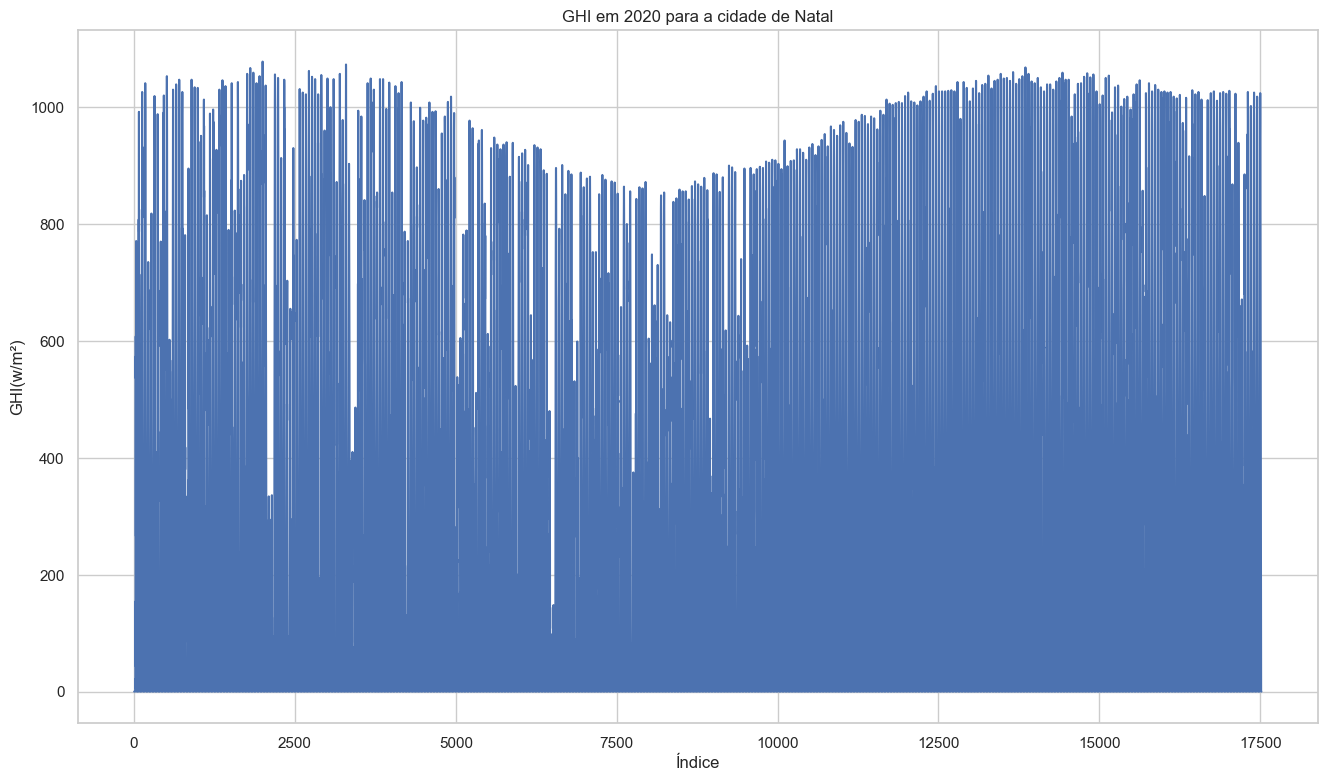

In [169]:
# Plota a coluna 'GHI' para o ano de 2020
plt.figure(figsize=(16, 9))
sns.lineplot(data=df[df['Year'] == 2020].reset_index(), x='index', y='GHI')
plt.title('GHI em 2020 para a cidade de Natal')
plt.xlabel('Índice')
plt.ylabel('GHI(w/m²)')
plt.savefig('GHI_2020_Natal.png', dpi=300, bbox_inches='tight')
plt.show()


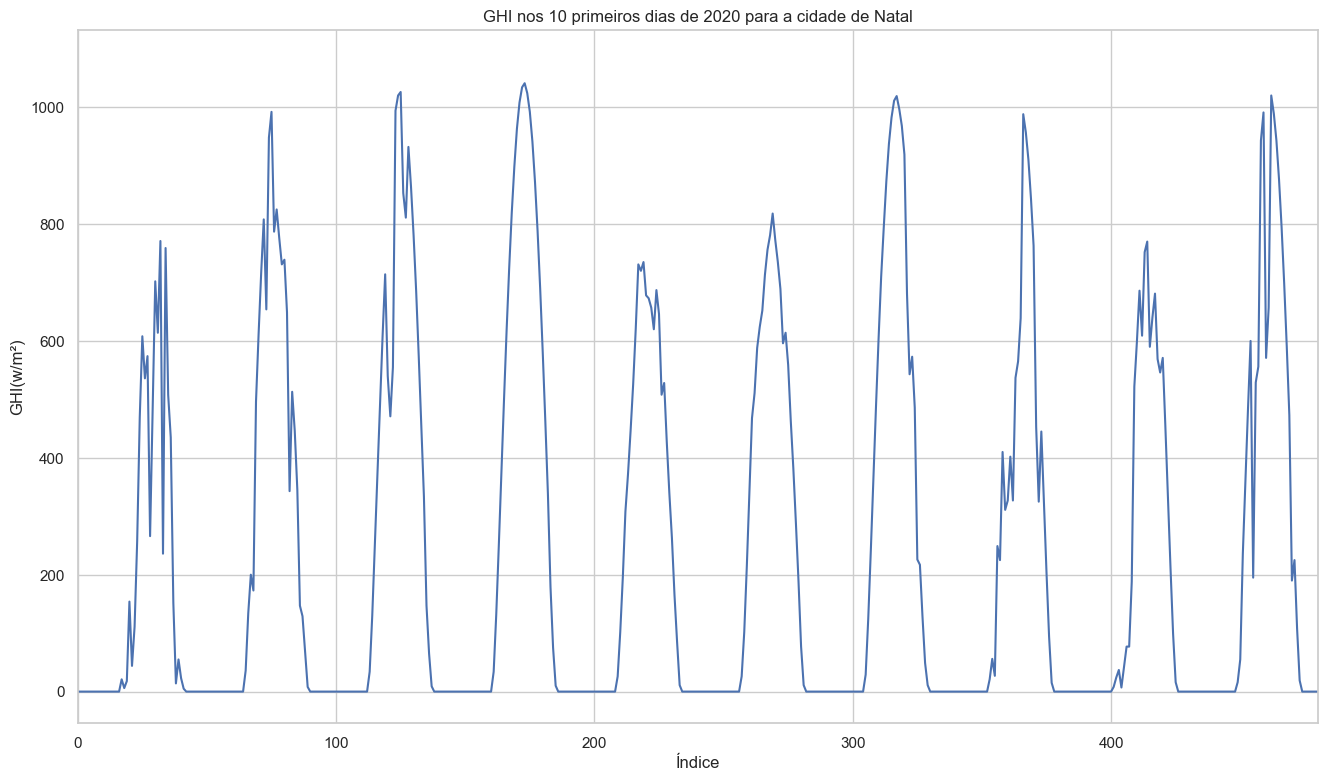

In [170]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df[df['Year'] == 2020].reset_index(), x='index', y='GHI')
plt.title('GHI nos 10 primeiros dias de 2020 para a cidade de Natal')
plt.xlabel('Índice')
plt.ylabel('GHI(w/m²)')
plt.xlim(0, 48*10)  # Limita o eixo x para mostrar apenas 10 dias
plt.savefig('GHI_10_dias_Natal.png', dpi=300, bbox_inches='tight')
plt.show()


In [171]:
df_train, df_test = data_scaling_split(df)


In [172]:
df_test

,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,DayOfYear,HourOfDay,City_Natal
0,0.411111,0.578313,0.0,0.734657,0.600000,0.377358,0.341667,0.588889,0.017213,0.000000,0.0
1,0.411111,0.578313,0.0,0.734657,0.600000,0.377358,0.338889,0.577778,0.017213,0.000000,0.0
2,0.400000,0.578313,0.0,0.742468,0.533333,0.377358,0.336111,0.577778,0.017213,0.258819,0.0
3,0.388889,0.578313,0.0,0.753850,0.533333,0.377358,0.330556,0.555556,0.017213,0.258819,0.0
4,0.388889,0.578313,0.0,0.752957,0.533333,0.377358,0.327778,0.544444,0.017213,0.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
35035,0.555556,0.638554,0.0,0.644276,0.400000,0.452830,0.319444,0.000000,0.017213,-0.707107,0.0
35036,0.544444,0.662651,0.0,0.672841,0.466667,0.452830,0.319444,0.000000,0.017213,-0.500000,0.0
35037,0.544444,0.662651,0.0,0.672841,0.466667,0.471698,0.319444,0.000000,0.017213,-0.500000,0.0
35038,0.533333,0.662651,0.0,0.693595,0.466667,0.471698,0.319444,0.000000,0.017213,-0.258819,0.0


# Definição dos modelos.

In [173]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Camada GRU
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # Camada de saída
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        # Se hidden não for fornecido, inicializa com zeros
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
        
        # Passa pela GRU
        out, hidden = self.gru(x, hidden)
        
        # Aplica a camada linear apenas na última saída temporal
        out = self.fc(out[:, -1, :])  # Pega apenas o último timestep
        
        return out
    
    def init_hidden(self, batch_size):
        # Inicializa o estado oculto com zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [174]:
# Implementação de um LSTM simples
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        if hidden is None:
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        else:
            h_0, c_0 = hidden

        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [175]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(SimpleMLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [176]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    
    def forward(self, y_pred, y_true):
        return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

# Função para treinamento do modelo.

In [177]:
def train_model(model, train_loader, test_loader, epochs, lr, patience=15, weight_decay=1e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = RMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

    best_test_loss = float('inf')
    patience_counter = 0
    train_losses = []
    test_losses = []
    best_model_state = None

    for epoch in range(epochs):
        # Treino
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze(-1)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        # Teste
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_loss += criterion(outputs.squeeze(), y_batch).item()

        train_loss /= len(train_loader)
        test_loss /= len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        scheduler.step(test_loss)

        # Early stopping baseado no teste
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping na época {epoch+1}")
                break

        if (epoch + 1) % 20 == 0:
            print(f'Época {epoch+1}/{epochs}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, test_losses, best_test_loss


# Função para plotar as perdas.

In [178]:
def plot_losses(train_losses, test_losses):
    """Plota as perdas de treino e teste """
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Losses durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [179]:
#Convertendo os dados de treino, validação e teste para tensores PyTorch
ghi_values_train = torch.tensor(df_train['GHI'].values, dtype=torch.float32).unsqueeze(-1)
ghi_values_test = torch.tensor(df_test['GHI'].values, dtype=torch.float32).unsqueeze(-1)

X_train = ghi_values_train[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y_train = ghi_values_train[1:].squeeze(-1)          # shape: (N-1, 1)
X_test = ghi_values_test[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y_test = ghi_values_test[1:].squeeze(-1)          # shape: (N-1, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [180]:
input_size = X_train.shape[-1]
model = SimpleMLP(input_size=input_size, hidden_size=20, output_size=1, num_layers = 2).to(device)
train_losses, test_losses, best_test_loss = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=100,
    lr=0.01,
    patience=15,
    weight_decay=1e-5
)

Época 20/100: Train Loss: 0.077081, Test Loss: 0.079284
Época 40/100: Train Loss: 0.076625, Test Loss: 0.079080
Época 60/100: Train Loss: 0.076531, Test Loss: 0.079007
Época 80/100: Train Loss: 0.076472, Test Loss: 0.078929
Época 100/100: Train Loss: 0.076462, Test Loss: 0.078898


# Função para otimizar hiperparâmetros.

In [181]:
def objective(trial, input_size, output_size, train_loader, test_loader,model_function=SimpleGRU):
    hidden_size = trial.suggest_int('hidden_size', 5, 30)
    num_layers = trial.suggest_int('num_layers', 1, 2)

    # Instantiate a new model with suggested hyperparameters
    model = model_function(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers).to(device)
    train_losses, test_losses, best_test_loss = train_model(
        model, train_loader, test_loader,
        epochs=100,
        lr=trial.suggest_loguniform('lr', 1e-5, 1e-2),
        weight_decay=trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    )

    return best_test_loss

def optimize_hyperparameters(train_loader, test_loader, input_size, output_size, n_trials=50, model_function=SimpleGRU):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, input_size, output_size, train_loader, test_loader,model_function), n_trials=n_trials)

    print("Best hyperparameters: ", study.best_params)
    print("Best validation loss: ", study.best_value)

    return study.best_params


In [182]:
best_params_mlp = optimize_hyperparameters(train_loader, test_loader, input_size, output_size=1, n_trials=20, model_function=SimpleMLP)
best_params_gru = optimize_hyperparameters(train_loader, test_loader, input_size, output_size=1, n_trials=20, model_function=SimpleGRU)
best_params_lstm = optimize_hyperparameters(train_loader, test_loader, input_size, output_size=1, n_trials=20, model_function=SimpleLSTM)
print("Melhores hiperparâmetros para MLP:", best_params_mlp)
print("Melhores hiperparâmetros para GRU:", best_params_gru)
print("Melhores hiperparâmetros para LSTM:", best_params_lstm)

[I 2025-07-14 22:40:03,498] A new study created in memory with name: no-name-ee4fb8d2-f9fa-4a43-87d5-ebaced57c0b0
C:\Users\Ric\AppData\Local\Temp\ipykernel_11832\2613755724.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr=trial.suggest_loguniform('lr', 1e-5, 1e-2),
C:\Users\Ric\AppData\Local\Temp\ipykernel_11832\2613755724.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
[I 2025-07-14 22:40:36,256] Trial 0 finished with value: 0.07934694894202496 and parameters: {'hidden_size': 10, 'num_layers': 1, 'lr': 0.0021134016435657545, 'weight_decay': 0.002038177214388111}. Best is trial 0 with value: 0

Early stopping na época 19
Época 20/100: Train Loss: 0.077324, Test Loss: 0.079223


[I 2025-07-14 22:41:59,451] Trial 1 finished with value: 0.0792223902104516 and parameters: {'hidden_size': 23, 'num_layers': 2, 'lr': 0.009267380920476338, 'weight_decay': 1.230344584485633e-05}. Best is trial 1 with value: 0.0792223902104516.


Early stopping na época 34
Época 20/100: Train Loss: 0.077224, Test Loss: 0.079617
Época 40/100: Train Loss: 0.076901, Test Loss: 0.079333
Época 60/100: Train Loss: 0.076882, Test Loss: 0.079313
Época 80/100: Train Loss: 0.076874, Test Loss: 0.079296


[I 2025-07-14 22:44:49,056] Trial 2 finished with value: 0.07929446272739128 and parameters: {'hidden_size': 11, 'num_layers': 1, 'lr': 3.537295005592163e-05, 'weight_decay': 0.0006122799015483259}. Best is trial 1 with value: 0.0792223902104516.


Época 100/100: Train Loss: 0.076873, Test Loss: 0.079294


[I 2025-07-14 22:45:36,476] Trial 3 finished with value: 0.07930050407319444 and parameters: {'hidden_size': 12, 'num_layers': 2, 'lr': 0.002245953766297876, 'weight_decay': 0.0011713072896767447}. Best is trial 1 with value: 0.0792223902104516.


Early stopping na época 17
Época 20/100: Train Loss: 0.076964, Test Loss: 0.079444
Época 40/100: Train Loss: 0.076846, Test Loss: 0.079271
Época 60/100: Train Loss: 0.076798, Test Loss: 0.079217
Época 80/100: Train Loss: 0.076785, Test Loss: 0.079180


[I 2025-07-14 22:50:26,632] Trial 4 finished with value: 0.0791674547475767 and parameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 7.442161199946467e-05, 'weight_decay': 2.0090053798649562e-05}. Best is trial 4 with value: 0.0791674547475767.


Época 100/100: Train Loss: 0.076778, Test Loss: 0.079167
Época 20/100: Train Loss: 0.076898, Test Loss: 0.079331
Época 40/100: Train Loss: 0.076827, Test Loss: 0.079243
Época 60/100: Train Loss: 0.076820, Test Loss: 0.079227
Época 80/100: Train Loss: 0.076819, Test Loss: 0.079224


[I 2025-07-14 22:53:32,306] Trial 5 finished with value: 0.07922395914027544 and parameters: {'hidden_size': 19, 'num_layers': 1, 'lr': 1.5711784902075e-05, 'weight_decay': 1.4114920170445473e-06}. Best is trial 4 with value: 0.0791674547475767.


Época 100/100: Train Loss: 0.076818, Test Loss: 0.079224


[I 2025-07-14 22:54:14,642] Trial 6 finished with value: 0.07931103231257772 and parameters: {'hidden_size': 29, 'num_layers': 2, 'lr': 0.0013522051821009036, 'weight_decay': 0.0028972591206023247}. Best is trial 4 with value: 0.0791674547475767.


Early stopping na época 19
Época 20/100: Train Loss: 0.076912, Test Loss: 0.079308


[I 2025-07-14 22:55:06,804] Trial 7 finished with value: 0.07930420835387625 and parameters: {'hidden_size': 29, 'num_layers': 1, 'lr': 0.0008931227631722556, 'weight_decay': 0.0005614066491551633}. Best is trial 4 with value: 0.0791674547475767.


Early stopping na época 32
Época 20/100: Train Loss: 0.076968, Test Loss: 0.079315
Época 40/100: Train Loss: 0.076851, Test Loss: 0.079312
Época 60/100: Train Loss: 0.076830, Test Loss: 0.079284
Época 80/100: Train Loss: 0.076821, Test Loss: 0.079259


[I 2025-07-14 22:57:49,036] Trial 8 finished with value: 0.0792571855351737 and parameters: {'hidden_size': 22, 'num_layers': 1, 'lr': 0.001923790390447123, 'weight_decay': 2.2863954776003408e-06}. Best is trial 4 with value: 0.0791674547475767.


Época 100/100: Train Loss: 0.076820, Test Loss: 0.079257
Época 20/100: Train Loss: 0.076803, Test Loss: 0.079253
Época 40/100: Train Loss: 0.076785, Test Loss: 0.079229
Época 60/100: Train Loss: 0.076777, Test Loss: 0.079181
Época 80/100: Train Loss: 0.076771, Test Loss: 0.079168


[I 2025-07-14 23:01:39,442] Trial 9 finished with value: 0.07916726209053165 and parameters: {'hidden_size': 18, 'num_layers': 2, 'lr': 0.00015084550176372338, 'weight_decay': 2.106507989722818e-05}. Best is trial 9 with value: 0.07916726209053165.


Época 100/100: Train Loss: 0.076770, Test Loss: 0.079167
Época 20/100: Train Loss: 0.076844, Test Loss: 0.079278
Época 40/100: Train Loss: 0.076837, Test Loss: 0.079240
Época 60/100: Train Loss: 0.076833, Test Loss: 0.079229
Época 80/100: Train Loss: 0.076832, Test Loss: 0.079229


[I 2025-07-14 23:05:19,202] Trial 10 finished with value: 0.07922846360225656 and parameters: {'hidden_size': 5, 'num_layers': 2, 'lr': 0.000176379992495948, 'weight_decay': 8.388859596772491e-05}. Best is trial 9 with value: 0.07916726209053165.


Época 100/100: Train Loss: 0.076832, Test Loss: 0.079228
Época 20/100: Train Loss: 0.076705, Test Loss: 0.079125
Época 40/100: Train Loss: 0.076683, Test Loss: 0.079101
Época 60/100: Train Loss: 0.076674, Test Loss: 0.079066
Época 80/100: Train Loss: 0.076669, Test Loss: 0.079060


[I 2025-07-14 23:09:04,311] Trial 11 finished with value: 0.07905985451214118 and parameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 9.53732587571571e-05, 'weight_decay': 4.6738485421988906e-05}. Best is trial 11 with value: 0.07905985451214118.


Época 100/100: Train Loss: 0.076669, Test Loss: 0.079060
Época 20/100: Train Loss: 0.076934, Test Loss: 0.079332
Época 40/100: Train Loss: 0.076876, Test Loss: 0.079248
Época 60/100: Train Loss: 0.076826, Test Loss: 0.079230
Época 80/100: Train Loss: 0.076814, Test Loss: 0.079194


[I 2025-07-14 23:12:55,905] Trial 12 finished with value: 0.07918804074939527 and parameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.00019249880989582975, 'weight_decay': 7.343798877522605e-05}. Best is trial 11 with value: 0.07905985451214118.


Época 100/100: Train Loss: 0.076808, Test Loss: 0.079188
Época 20/100: Train Loss: 0.076862, Test Loss: 0.079311
Época 40/100: Train Loss: 0.076715, Test Loss: 0.079149
Época 60/100: Train Loss: 0.076692, Test Loss: 0.079104
Época 80/100: Train Loss: 0.076679, Test Loss: 0.079078


[I 2025-07-14 23:16:49,494] Trial 13 finished with value: 0.07907600574467552 and parameters: {'hidden_size': 21, 'num_layers': 2, 'lr': 6.8879349742157e-05, 'weight_decay': 1.4217453956255293e-05}. Best is trial 11 with value: 0.07905985451214118.


Época 100/100: Train Loss: 0.076677, Test Loss: 0.079076
Época 20/100: Train Loss: 0.077761, Test Loss: 0.080258
Época 40/100: Train Loss: 0.076957, Test Loss: 0.079402
Época 60/100: Train Loss: 0.076916, Test Loss: 0.079346
Época 80/100: Train Loss: 0.076888, Test Loss: 0.079310


[I 2025-07-14 23:20:44,565] Trial 14 finished with value: 0.07927932179358588 and parameters: {'hidden_size': 25, 'num_layers': 2, 'lr': 1.0545918778015677e-05, 'weight_decay': 5.419229176253143e-06}. Best is trial 11 with value: 0.07905985451214118.


Época 100/100: Train Loss: 0.076865, Test Loss: 0.079279
Época 20/100: Train Loss: 0.076837, Test Loss: 0.079278
Época 40/100: Train Loss: 0.076803, Test Loss: 0.079248
Época 60/100: Train Loss: 0.076793, Test Loss: 0.079209
Época 80/100: Train Loss: 0.076790, Test Loss: 0.079204


[I 2025-07-14 23:24:38,884] Trial 15 finished with value: 0.0792030062245792 and parameters: {'hidden_size': 21, 'num_layers': 2, 'lr': 4.390859275358564e-05, 'weight_decay': 0.00017278666325265066}. Best is trial 11 with value: 0.07905985451214118.


Época 100/100: Train Loss: 0.076789, Test Loss: 0.079203
Época 20/100: Train Loss: 0.076891, Test Loss: 0.079325
Época 40/100: Train Loss: 0.076861, Test Loss: 0.079285
Época 60/100: Train Loss: 0.076855, Test Loss: 0.079262
Época 80/100: Train Loss: 0.076853, Test Loss: 0.079260


[I 2025-07-14 23:28:18,800] Trial 16 finished with value: 0.0792596039536609 and parameters: {'hidden_size': 14, 'num_layers': 2, 'lr': 0.0004416755390191467, 'weight_decay': 4.6444854257507185e-05}. Best is trial 11 with value: 0.07905985451214118.


Época 100/100: Train Loss: 0.076852, Test Loss: 0.079260
Época 20/100: Train Loss: 0.076830, Test Loss: 0.079297
Época 40/100: Train Loss: 0.076789, Test Loss: 0.079226
Época 60/100: Train Loss: 0.076772, Test Loss: 0.079208
Época 80/100: Train Loss: 0.076760, Test Loss: 0.079164


[I 2025-07-14 23:32:06,182] Trial 17 finished with value: 0.07915468070247811 and parameters: {'hidden_size': 26, 'num_layers': 2, 'lr': 7.588205449691549e-05, 'weight_decay': 0.00026875278181102974}. Best is trial 11 with value: 0.07905985451214118.


Época 100/100: Train Loss: 0.076754, Test Loss: 0.079155
Época 20/100: Train Loss: 0.078155, Test Loss: 0.080441
Época 40/100: Train Loss: 0.076972, Test Loss: 0.079424
Época 60/100: Train Loss: 0.076928, Test Loss: 0.079380
Época 80/100: Train Loss: 0.076916, Test Loss: 0.079347


[I 2025-07-14 23:35:58,854] Trial 18 finished with value: 0.07934185386078271 and parameters: {'hidden_size': 8, 'num_layers': 2, 'lr': 2.6255743991475525e-05, 'weight_decay': 3.29886448008865e-06}. Best is trial 11 with value: 0.07905985451214118.


Época 100/100: Train Loss: 0.076914, Test Loss: 0.079342
Época 20/100: Train Loss: 0.076824, Test Loss: 0.079196
Época 40/100: Train Loss: 0.076730, Test Loss: 0.079172
Época 60/100: Train Loss: 0.076706, Test Loss: 0.079140
Época 80/100: Train Loss: 0.076694, Test Loss: 0.079115


[I 2025-07-14 23:40:02,268] Trial 19 finished with value: 0.07911380655281075 and parameters: {'hidden_size': 20, 'num_layers': 2, 'lr': 0.000466783581930946, 'weight_decay': 7.348504978646918e-06}. Best is trial 11 with value: 0.07905985451214118.
[I 2025-07-14 23:40:02,269] A new study created in memory with name: no-name-2f4d5494-df83-4913-a413-3591364c19d6


Época 100/100: Train Loss: 0.076692, Test Loss: 0.079114
Best hyperparameters:  {'hidden_size': 16, 'num_layers': 2, 'lr': 9.53732587571571e-05, 'weight_decay': 4.6738485421988906e-05}
Best validation loss:  0.07905985451214118
Época 20/100: Train Loss: 0.077018, Test Loss: 0.079474


[I 2025-07-14 23:41:10,557] Trial 0 finished with value: 0.07942328114215642 and parameters: {'hidden_size': 9, 'num_layers': 1, 'lr': 0.0036059450278554638, 'weight_decay': 4.977211291005836e-05}. Best is trial 0 with value: 0.07942328114215642.


Early stopping na época 24
Época 20/100: Train Loss: 0.076950, Test Loss: 0.079459


[I 2025-07-14 23:43:15,906] Trial 1 finished with value: 0.07944829140419829 and parameters: {'hidden_size': 24, 'num_layers': 2, 'lr': 0.00037533642308213745, 'weight_decay': 1.2610827318231457e-05}. Best is trial 0 with value: 0.07942328114215642.


Early stopping na época 33
Época 20/100: Train Loss: 0.076972, Test Loss: 0.079403
Época 40/100: Train Loss: 0.076964, Test Loss: 0.079394
Época 60/100: Train Loss: 0.076962, Test Loss: 0.079392
Época 80/100: Train Loss: 0.076962, Test Loss: 0.079391


[I 2025-07-14 23:47:41,712] Trial 2 finished with value: 0.07939145744748448 and parameters: {'hidden_size': 9, 'num_layers': 1, 'lr': 3.655124748417701e-05, 'weight_decay': 3.5586243153721083e-06}. Best is trial 2 with value: 0.07939145744748448.


Early stopping na época 93
Época 20/100: Train Loss: 0.076999, Test Loss: 0.079458


[I 2025-07-14 23:49:12,707] Trial 3 finished with value: 0.07940435818477308 and parameters: {'hidden_size': 22, 'num_layers': 2, 'lr': 0.0010220853198115868, 'weight_decay': 4.87456701789271e-05}. Best is trial 2 with value: 0.07939145744748448.


Early stopping na época 24


[I 2025-07-14 23:49:58,821] Trial 4 finished with value: 0.07936212557737958 and parameters: {'hidden_size': 24, 'num_layers': 1, 'lr': 0.00166146524082475, 'weight_decay': 0.00011688437560675039}. Best is trial 4 with value: 0.07936212557737958.


Early stopping na época 16


[I 2025-07-14 23:51:07,222] Trial 5 finished with value: 0.07947718024968284 and parameters: {'hidden_size': 24, 'num_layers': 2, 'lr': 0.000394591966749879, 'weight_decay': 2.3926130232882416e-06}. Best is trial 4 with value: 0.07936212557737958.


Early stopping na época 18
Época 20/100: Train Loss: 0.076941, Test Loss: 0.079437


[I 2025-07-14 23:52:31,790] Trial 6 finished with value: 0.07942291895293346 and parameters: {'hidden_size': 28, 'num_layers': 2, 'lr': 0.00012718558573884494, 'weight_decay': 0.00013176951245618613}. Best is trial 4 with value: 0.07936212557737958.


Early stopping na época 22
Época 20/100: Train Loss: 0.077017, Test Loss: 0.079410
Época 40/100: Train Loss: 0.076974, Test Loss: 0.079375
Época 60/100: Train Loss: 0.076947, Test Loss: 0.079355
Época 80/100: Train Loss: 0.076938, Test Loss: 0.079347


[I 2025-07-14 23:57:21,322] Trial 7 finished with value: 0.07934550970588646 and parameters: {'hidden_size': 26, 'num_layers': 1, 'lr': 1.2168904881988983e-05, 'weight_decay': 0.0013048254542648529}. Best is trial 7 with value: 0.07934550970588646.


Época 100/100: Train Loss: 0.076936, Test Loss: 0.079346
Época 20/100: Train Loss: 0.076937, Test Loss: 0.079348
Época 40/100: Train Loss: 0.076923, Test Loss: 0.079329
Época 60/100: Train Loss: 0.076920, Test Loss: 0.079328
Época 80/100: Train Loss: 0.076919, Test Loss: 0.079328


[I 2025-07-15 00:02:01,888] Trial 8 finished with value: 0.0793280787740464 and parameters: {'hidden_size': 24, 'num_layers': 1, 'lr': 3.977744609342973e-05, 'weight_decay': 0.0032407585068355014}. Best is trial 8 with value: 0.0793280787740464.


Early stopping na época 97
Época 20/100: Train Loss: 0.076935, Test Loss: 0.079370
Época 40/100: Train Loss: 0.076928, Test Loss: 0.079353
Época 60/100: Train Loss: 0.076926, Test Loss: 0.079351
Época 80/100: Train Loss: 0.076925, Test Loss: 0.079350


[I 2025-07-15 00:06:48,130] Trial 9 finished with value: 0.0793502923296807 and parameters: {'hidden_size': 20, 'num_layers': 1, 'lr': 0.00010177999876170678, 'weight_decay': 8.625534270364879e-06}. Best is trial 8 with value: 0.0793280787740464.


Época 100/100: Train Loss: 0.076925, Test Loss: 0.079351
Época 20/100: Train Loss: 0.077541, Test Loss: 0.079853


[I 2025-07-15 00:07:59,082] Trial 10 finished with value: 0.07969748240270436 and parameters: {'hidden_size': 15, 'num_layers': 1, 'lr': 0.009862726381209433, 'weight_decay': 0.009836854160426407}. Best is trial 8 with value: 0.0793280787740464.


Early stopping na época 25
Época 20/100: Train Loss: 0.077078, Test Loss: 0.079393
Época 40/100: Train Loss: 0.076945, Test Loss: 0.079338
Época 60/100: Train Loss: 0.076934, Test Loss: 0.079333
Época 80/100: Train Loss: 0.076932, Test Loss: 0.079333


[I 2025-07-15 00:12:48,731] Trial 11 finished with value: 0.07933289253633452 and parameters: {'hidden_size': 29, 'num_layers': 1, 'lr': 1.0540110096036216e-05, 'weight_decay': 0.003558306210395019}. Best is trial 8 with value: 0.0793280787740464.


Época 100/100: Train Loss: 0.076932, Test Loss: 0.079333
Época 20/100: Train Loss: 0.076996, Test Loss: 0.079382
Época 40/100: Train Loss: 0.076946, Test Loss: 0.079345
Época 60/100: Train Loss: 0.076930, Test Loss: 0.079335
Época 80/100: Train Loss: 0.076928, Test Loss: 0.079333


[I 2025-07-15 00:17:37,675] Trial 12 finished with value: 0.07933296871511904 and parameters: {'hidden_size': 30, 'num_layers': 1, 'lr': 1.0265734475054426e-05, 'weight_decay': 0.00234502591786426}. Best is trial 8 with value: 0.0793280787740464.


Época 100/100: Train Loss: 0.076927, Test Loss: 0.079333
Época 20/100: Train Loss: 0.076947, Test Loss: 0.079372
Época 40/100: Train Loss: 0.076942, Test Loss: 0.079366
Época 60/100: Train Loss: 0.076941, Test Loss: 0.079365
Época 80/100: Train Loss: 0.076941, Test Loss: 0.079365


[I 2025-07-15 00:21:53,399] Trial 13 finished with value: 0.07936496516885279 and parameters: {'hidden_size': 15, 'num_layers': 1, 'lr': 3.5454757261848466e-05, 'weight_decay': 0.0008924135464669191}. Best is trial 8 with value: 0.0793280787740464.


Early stopping na época 90
Época 20/100: Train Loss: 0.077064, Test Loss: 0.079401
Época 40/100: Train Loss: 0.077041, Test Loss: 0.079402


[I 2025-07-15 00:23:56,852] Trial 14 finished with value: 0.07939463392002126 and parameters: {'hidden_size': 30, 'num_layers': 1, 'lr': 2.7059702223591683e-05, 'weight_decay': 0.009634627843753895}. Best is trial 8 with value: 0.0793280787740464.


Early stopping na época 43
Época 20/100: Train Loss: 0.076918, Test Loss: 0.079375
Época 40/100: Train Loss: 0.076913, Test Loss: 0.079343
Época 60/100: Train Loss: 0.076910, Test Loss: 0.079337
Época 80/100: Train Loss: 0.076909, Test Loss: 0.079336


[I 2025-07-15 07:42:29,279] Trial 15 finished with value: 0.07933553995130813 and parameters: {'hidden_size': 20, 'num_layers': 1, 'lr': 0.00012697429307056865, 'weight_decay': 0.00046665467424882625}. Best is trial 8 with value: 0.0793280787740464.


Época 100/100: Train Loss: 0.076909, Test Loss: 0.079336
Época 20/100: Train Loss: 0.076953, Test Loss: 0.079353
Época 40/100: Train Loss: 0.076942, Test Loss: 0.079347
Época 60/100: Train Loss: 0.076941, Test Loss: 0.079347
Época 80/100: Train Loss: 0.076940, Test Loss: 0.079347


[I 2025-07-15 07:46:34,227] Trial 16 finished with value: 0.07934687335435386 and parameters: {'hidden_size': 17, 'num_layers': 1, 'lr': 2.1010305612200847e-05, 'weight_decay': 0.0032285150267897973}. Best is trial 8 with value: 0.0793280787740464.


Early stopping na época 92
Época 20/100: Train Loss: 0.076950, Test Loss: 0.079428
Época 40/100: Train Loss: 0.076948, Test Loss: 0.079392
Época 60/100: Train Loss: 0.076945, Test Loss: 0.079379
Época 80/100: Train Loss: 0.076944, Test Loss: 0.079378


[I 2025-07-15 07:52:44,088] Trial 17 finished with value: 0.07937813709196571 and parameters: {'hidden_size': 28, 'num_layers': 2, 'lr': 6.67743124274145e-05, 'weight_decay': 0.00034261270556687696}. Best is trial 8 with value: 0.0793280787740464.


Época 100/100: Train Loss: 0.076944, Test Loss: 0.079378
Época 20/100: Train Loss: 0.077082, Test Loss: 0.079503


[I 2025-07-15 07:54:29,932] Trial 18 finished with value: 0.07949969148322872 and parameters: {'hidden_size': 6, 'num_layers': 1, 'lr': 6.167068327690242e-05, 'weight_decay': 0.004360610357745941}. Best is trial 8 with value: 0.0793280787740464.


Early stopping na época 39
Época 20/100: Train Loss: 0.077003, Test Loss: 0.079411
Época 40/100: Train Loss: 0.076968, Test Loss: 0.079383
Época 60/100: Train Loss: 0.076950, Test Loss: 0.079365
Época 80/100: Train Loss: 0.076947, Test Loss: 0.079362


[I 2025-07-15 07:59:23,674] Trial 19 finished with value: 0.07936111697544382 and parameters: {'hidden_size': 27, 'num_layers': 1, 'lr': 1.6796137173658842e-05, 'weight_decay': 0.0003982437703194071}. Best is trial 8 with value: 0.0793280787740464.
[I 2025-07-15 07:59:23,676] A new study created in memory with name: no-name-123aeeee-ad94-4b58-857d-6594fb8d9dfb


Época 100/100: Train Loss: 0.076946, Test Loss: 0.079361
Best hyperparameters:  {'hidden_size': 24, 'num_layers': 1, 'lr': 3.977744609342973e-05, 'weight_decay': 0.0032407585068355014}
Best validation loss:  0.0793280787740464


[I 2025-07-15 08:00:27,725] Trial 0 finished with value: 0.08030897384790117 and parameters: {'hidden_size': 20, 'num_layers': 2, 'lr': 0.0025566701453289013, 'weight_decay': 0.007676235478627564}. Best is trial 0 with value: 0.08030897384790117.


Early stopping na época 16
Época 20/100: Train Loss: 0.077179, Test Loss: 0.079404
Época 40/100: Train Loss: 0.077070, Test Loss: 0.079265
Época 60/100: Train Loss: 0.076858, Test Loss: 0.079261


[I 2025-07-15 08:04:44,970] Trial 1 finished with value: 0.07925740060009505 and parameters: {'hidden_size': 20, 'num_layers': 2, 'lr': 0.0008988725136751518, 'weight_decay': 4.4092704193325034e-06}. Best is trial 1 with value: 0.07925740060009505.


Early stopping na época 64


[I 2025-07-15 08:05:51,749] Trial 2 finished with value: 0.079762564301831 and parameters: {'hidden_size': 13, 'num_layers': 2, 'lr': 0.001632552536144803, 'weight_decay': 0.0022011510743169043}. Best is trial 1 with value: 0.07925740060009505.


Early stopping na época 17
Época 20/100: Train Loss: 0.077318, Test Loss: 0.079714
Época 40/100: Train Loss: 0.077059, Test Loss: 0.079500
Época 60/100: Train Loss: 0.077017, Test Loss: 0.079463
Época 80/100: Train Loss: 0.077011, Test Loss: 0.079456


[I 2025-07-15 08:12:37,495] Trial 3 finished with value: 0.07945443318910114 and parameters: {'hidden_size': 25, 'num_layers': 2, 'lr': 1.0691414511500616e-05, 'weight_decay': 3.1531965273942692e-06}. Best is trial 1 with value: 0.07925740060009505.


Época 100/100: Train Loss: 0.077010, Test Loss: 0.079454
Época 20/100: Train Loss: 0.077295, Test Loss: 0.079231
Época 40/100: Train Loss: 0.076998, Test Loss: 0.079254


[I 2025-07-15 08:16:07,076] Trial 4 finished with value: 0.07919643846974117 and parameters: {'hidden_size': 21, 'num_layers': 2, 'lr': 0.001795777366159885, 'weight_decay': 1.9248472309738666e-06}. Best is trial 4 with value: 0.07919643846974117.


Early stopping na época 52
Época 20/100: Train Loss: 0.076984, Test Loss: 0.079476
Época 40/100: Train Loss: 0.076981, Test Loss: 0.079432
Época 60/100: Train Loss: 0.076978, Test Loss: 0.079422
Época 80/100: Train Loss: 0.076977, Test Loss: 0.079420


[I 2025-07-15 08:21:05,117] Trial 5 finished with value: 0.0794195721921039 and parameters: {'hidden_size': 17, 'num_layers': 1, 'lr': 0.00017574760295708083, 'weight_decay': 5.771323922788797e-05}. Best is trial 4 with value: 0.07919643846974117.


Época 100/100: Train Loss: 0.076976, Test Loss: 0.079420
Época 20/100: Train Loss: 0.094158, Test Loss: 0.087567
Época 40/100: Train Loss: 0.077458, Test Loss: 0.079950
Época 60/100: Train Loss: 0.077452, Test Loss: 0.079942
Época 80/100: Train Loss: 0.077450, Test Loss: 0.079940


[I 2025-07-15 08:28:08,276] Trial 6 finished with value: 0.07994033824312224 and parameters: {'hidden_size': 9, 'num_layers': 2, 'lr': 1.2382582483694082e-05, 'weight_decay': 4.199120624150322e-06}. Best is trial 4 with value: 0.07919643846974117.


Early stopping na época 99
Época 20/100: Train Loss: 0.077600, Test Loss: 0.079663
Época 40/100: Train Loss: 0.077445, Test Loss: 0.079411
Época 60/100: Train Loss: 0.077282, Test Loss: 0.079220
Época 80/100: Train Loss: 0.077021, Test Loss: 0.079261


[I 2025-07-15 08:32:51,875] Trial 7 finished with value: 0.07920659505443214 and parameters: {'hidden_size': 13, 'num_layers': 1, 'lr': 0.0051072526442277125, 'weight_decay': 1.4134771020708912e-05}. Best is trial 4 with value: 0.07919643846974117.


Early stopping na época 88
Época 20/100: Train Loss: 0.077133, Test Loss: 0.079525
Época 40/100: Train Loss: 0.077005, Test Loss: 0.079424
Época 60/100: Train Loss: 0.076973, Test Loss: 0.079396
Época 80/100: Train Loss: 0.076967, Test Loss: 0.079391


[I 2025-07-15 08:38:29,476] Trial 8 finished with value: 0.07939011388751742 and parameters: {'hidden_size': 20, 'num_layers': 1, 'lr': 2.948504975783424e-05, 'weight_decay': 0.0008690728774412117}. Best is trial 4 with value: 0.07919643846974117.


Época 100/100: Train Loss: 0.076966, Test Loss: 0.079390
Época 20/100: Train Loss: 0.077067, Test Loss: 0.079480
Época 40/100: Train Loss: 0.076986, Test Loss: 0.079427
Época 60/100: Train Loss: 0.076976, Test Loss: 0.079404
Época 80/100: Train Loss: 0.076974, Test Loss: 0.079403


[I 2025-07-15 08:43:27,583] Trial 9 finished with value: 0.07940240132975387 and parameters: {'hidden_size': 18, 'num_layers': 1, 'lr': 4.605637543183646e-05, 'weight_decay': 0.0009342188709948325}. Best is trial 4 with value: 0.07919643846974117.


Época 100/100: Train Loss: 0.076974, Test Loss: 0.079402
Época 20/100: Train Loss: 0.077033, Test Loss: 0.079568
Época 40/100: Train Loss: 0.077029, Test Loss: 0.079522
Época 60/100: Train Loss: 0.077026, Test Loss: 0.079481
Época 80/100: Train Loss: 0.077023, Test Loss: 0.079474


[I 2025-07-15 08:50:20,786] Trial 10 finished with value: 0.07947296458445319 and parameters: {'hidden_size': 29, 'num_layers': 2, 'lr': 0.0003443934837893114, 'weight_decay': 4.4395492299051714e-05}. Best is trial 4 with value: 0.07919643846974117.


Época 100/100: Train Loss: 0.077023, Test Loss: 0.079473
Época 20/100: Train Loss: 0.077502, Test Loss: 0.079466
Época 40/100: Train Loss: 0.077387, Test Loss: 0.079364
Época 60/100: Train Loss: 0.077358, Test Loss: 0.079334
Época 80/100: Train Loss: 0.077335, Test Loss: 0.079313


[I 2025-07-15 08:55:12,750] Trial 11 finished with value: 0.07928892977824903 and parameters: {'hidden_size': 8, 'num_layers': 1, 'lr': 0.008994967419517406, 'weight_decay': 1.1310012355385279e-06}. Best is trial 4 with value: 0.07919643846974117.


Época 100/100: Train Loss: 0.077299, Test Loss: 0.079289
Época 20/100: Train Loss: 0.077385, Test Loss: 0.079403
Época 40/100: Train Loss: 0.077254, Test Loss: 0.079224


[I 2025-07-15 08:58:05,872] Trial 12 finished with value: 0.0792204739559935 and parameters: {'hidden_size': 13, 'num_layers': 1, 'lr': 0.009624206717622173, 'weight_decay': 2.0554114309156138e-05}. Best is trial 4 with value: 0.07919643846974117.


Early stopping na época 59
Época 20/100: Train Loss: 0.077335, Test Loss: 0.079528
Época 40/100: Train Loss: 0.077170, Test Loss: 0.079255
Época 60/100: Train Loss: 0.077127, Test Loss: 0.079216


[I 2025-07-15 09:01:51,282] Trial 13 finished with value: 0.07921610714093735 and parameters: {'hidden_size': 5, 'num_layers': 1, 'lr': 0.0035071611846533308, 'weight_decay': 1.3678112392736184e-05}. Best is trial 4 with value: 0.07919643846974117.


Early stopping na época 76


[I 2025-07-15 09:02:48,604] Trial 14 finished with value: 0.0794348264904055 and parameters: {'hidden_size': 25, 'num_layers': 1, 'lr': 0.0006322380840533467, 'weight_decay': 0.00018133161647168144}. Best is trial 4 with value: 0.07919643846974117.


Early stopping na época 19
Época 20/100: Train Loss: 0.077486, Test Loss: 0.079286
Época 40/100: Train Loss: 0.077084, Test Loss: 0.079232
Época 60/100: Train Loss: 0.076874, Test Loss: 0.079240


[I 2025-07-15 09:06:50,479] Trial 15 finished with value: 0.07923027094215426 and parameters: {'hidden_size': 14, 'num_layers': 2, 'lr': 0.003991245548187262, 'weight_decay': 1.2957794872980266e-06}. Best is trial 4 with value: 0.07919643846974117.


Early stopping na época 61
Época 20/100: Train Loss: 0.077454, Test Loss: 0.079513
Época 40/100: Train Loss: 0.077411, Test Loss: 0.079491
Época 60/100: Train Loss: 0.077349, Test Loss: 0.079432
Época 80/100: Train Loss: 0.077242, Test Loss: 0.079306


[I 2025-07-15 20:40:13,040] Trial 16 finished with value: 0.07924384381622077 and parameters: {'hidden_size': 24, 'num_layers': 2, 'lr': 0.0012503376644712402, 'weight_decay': 1.0185499456980372e-05}. Best is trial 4 with value: 0.07919643846974117.


Época 100/100: Train Loss: 0.077182, Test Loss: 0.079244
Época 20/100: Train Loss: 0.076944, Test Loss: 0.079413
Época 40/100: Train Loss: 0.076939, Test Loss: 0.079377
Época 60/100: Train Loss: 0.076936, Test Loss: 0.079368
Época 80/100: Train Loss: 0.076935, Test Loss: 0.079366


[I 2025-07-15 20:45:09,807] Trial 17 finished with value: 0.07936610240982547 and parameters: {'hidden_size': 30, 'num_layers': 1, 'lr': 0.00016197794586553485, 'weight_decay': 0.00020575422015592696}. Best is trial 4 with value: 0.07919643846974117.


Época 100/100: Train Loss: 0.076935, Test Loss: 0.079366
Época 20/100: Train Loss: 0.077279, Test Loss: 0.079209


[I 2025-07-15 20:47:28,185] Trial 18 finished with value: 0.07920830536837856 and parameters: {'hidden_size': 15, 'num_layers': 2, 'lr': 0.005491809090402962, 'weight_decay': 7.149483697776798e-06}. Best is trial 4 with value: 0.07919643846974117.


Early stopping na época 38
Época 20/100: Train Loss: 0.077031, Test Loss: 0.079544
Época 40/100: Train Loss: 0.077016, Test Loss: 0.079523
Época 60/100: Train Loss: 0.076986, Test Loss: 0.079476
Época 80/100: Train Loss: 0.076980, Test Loss: 0.079428


[I 2025-07-15 20:52:08,954] Trial 19 finished with value: 0.07942236978815843 and parameters: {'hidden_size': 11, 'num_layers': 1, 'lr': 0.0004687815331219373, 'weight_decay': 3.112448046088695e-05}. Best is trial 4 with value: 0.07919643846974117.


Época 100/100: Train Loss: 0.076977, Test Loss: 0.079422
Best hyperparameters:  {'hidden_size': 21, 'num_layers': 2, 'lr': 0.001795777366159885, 'weight_decay': 1.9248472309738666e-06}
Best validation loss:  0.07919643846974117
Melhores hiperparâmetros para MLP: {'hidden_size': 16, 'num_layers': 2, 'lr': 9.53732587571571e-05, 'weight_decay': 4.6738485421988906e-05}
Melhores hiperparâmetros para GRU: {'hidden_size': 24, 'num_layers': 1, 'lr': 3.977744609342973e-05, 'weight_decay': 0.0032407585068355014}
Melhores hiperparâmetros para LSTM: {'hidden_size': 21, 'num_layers': 2, 'lr': 0.001795777366159885, 'weight_decay': 1.9248472309738666e-06}
